[1.6242452488973755, 0.17964540182288166, 0.057500482345328195, 0.02083413708075989, 0.007750943311275981, 0.0038300885234754446, 0.004954641498956373, 0.00500661215803903, 0.005665680715480985, 0.005742229534108468, 0.005617865394011731, 0.005907667571615644, 0.00585889910501989, 0.010964663061696559, 0.011048117654163215, 0.018615843976206057, 0.011684189775187419, 0.011672705057558635, 0.019788623665883676, 0.019593225253181756, 0.021921817126583122, 0.02329584016724749, 0.023351681508734033, 0.02229238864478447, 0.023296657410943018, 0.021458309243545394, 0.039552868600312874, 0.04465440786202805, 0.023287503503602917, 0.022708393807144366, 0.022597090691652343, 0.03711001814461201, 0.046580396847463484, 0.03968950144594239, 0.04417251158106862, 0.046046834031403555, 0.0443644223772547, 0.043649194175011966, 0.0461806054677588, 0.07990010719176155, 0.08100053259310824, 0.04538553648414737, 0.04689847048492683, 0.04013774040315871, 0.04495883854085814, 0.04535470394628552, 0.0447695

/var/folders/vw/ymfkrry911gbtmst1lhp6kjh0000gn/T/ipykernel_8024/3691038516.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(8, 16))


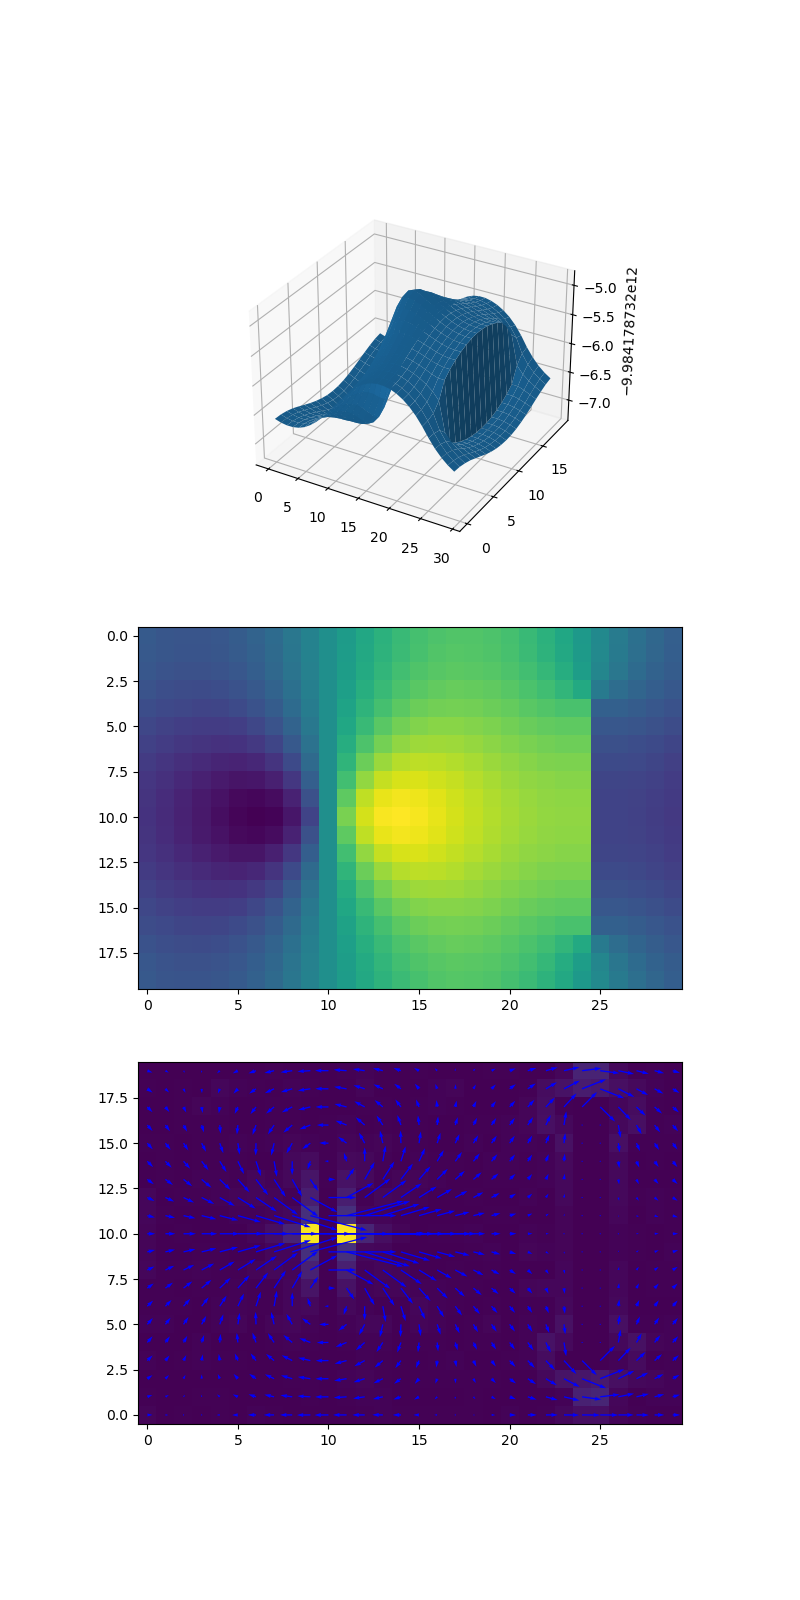

In [23]:
# If constraints for the poisson boundary AND the interior overlap, solution doesn't
# converge.
%matplotlib widget
import matplotlib.pyplot as plt
import importlib
import navier_stokes
importlib.reload(navier_stokes)
import numpy as np

height = 20
width = 30

grid = np.zeros(shape=(height,width))
grid[3:18, 24:26] = 1
cells = navier_stokes.cells(grid)
vf = np.zeros(cells.shape + (2,))

# Circular force field, still has divergence problem.
center = np.array([10,10])
for j,i in np.ndindex(cells.shape):
    if not isinstance(cells[j][i], navier_stokes.FluidCell):
        continue
    invec = np.array([i,j])
    dist = np.linalg.norm(center - invec)
    v = 2*np.exp(-dist/2)
    # If the limit is 10, the solution converges.
    if dist > 13:
        v = 0

    vf[j][i] = [v, 0]

hd = navier_stokes.HelmholtzDecomposition(cells)

residuals = []
vf, P = hd.solenoidalPart(vf, residuals)
print(residuals)
divfield = np.zeros(cells.shape)
for fc in cells.flat:
    if isinstance(fc, navier_stokes.ObstacleInteriorCell):
        P[fc.index] = None
        continue
    if not isinstance(fc, navier_stokes.FluidCell):
        continue
    xdiff = (vf[fc.right.index][0] - vf[fc.left.index][0]) / 2
    ydiff = (vf[fc.up.index][1] - vf[fc.down.index][1]) / 2
    divergence = xdiff + ydiff
    divfield[fc.index] = np.abs(divergence)

X, Y = np.meshgrid(np.arange(width), np.arange(height))

fig = plt.figure(figsize=(8, 16))
ax = fig.add_subplot(311, projection='3d')
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)

ax.plot_surface(X, Y, P)
ax2.imshow(P, interpolation='none')
ax3.imshow(divfield, interpolation='none', origin='lower')
ax3.quiver(X, Y, vf[:, :, 0], vf[:, :, 1], color="b")

plt.show()